In [2]:
import keras
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, Conv2D
from keras.models import Model, Sequential, model_from_yaml 
from keras import applications, optimizers
from vis.utils import utils
from keras import activations
from keras.models import Sequential, load_model
weights_path = 'VGG16_weights_aug.h5'

# load json and create model
yaml_file = open('fine_tune_VGG_model_aug.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(weights_path)

print("Loaded model from disk")
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print('Layer dict', layer_dict)
print(model.summary())

Loaded model from disk
Layer dict {'input_1': <keras.engine.topology.InputLayer object at 0x108d5d908>, 'block1_conv1': <keras.layers.convolutional.Conv2D object at 0x108d5d0f0>, 'block1_conv2': <keras.layers.convolutional.Conv2D object at 0x11f32f5f8>, 'block1_pool': <keras.layers.pooling.MaxPooling2D object at 0x11f32f080>, 'block2_conv1': <keras.layers.convolutional.Conv2D object at 0x11f32f390>, 'block2_conv2': <keras.layers.convolutional.Conv2D object at 0x11f32f9b0>, 'block2_pool': <keras.layers.pooling.MaxPooling2D object at 0x11f32fd30>, 'block3_conv1': <keras.layers.convolutional.Conv2D object at 0x11f32fcc0>, 'block3_conv2': <keras.layers.convolutional.Conv2D object at 0x11f32ff28>, 'block3_conv3': <keras.layers.convolutional.Conv2D object at 0x11f3341d0>, 'block3_pool': <keras.layers.pooling.MaxPooling2D object at 0x11f334320>, 'block4_conv1': <keras.layers.convolutional.Conv2D object at 0x11f334588>, 'block4_conv2': <keras.layers.convolutional.Conv2D object at 0x11f334400>,

In [3]:
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'block5_conv1')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/anaconda/envs/mypython3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda/envs/mypython3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


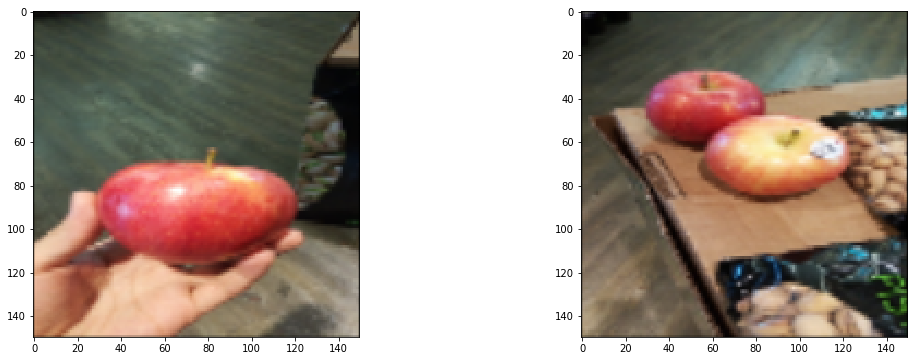

In [4]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('data/train/apple_0.png', target_size=(150, 150))
img2 = utils.load_img('data/train/apple_1.png', target_size=(150, 150))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

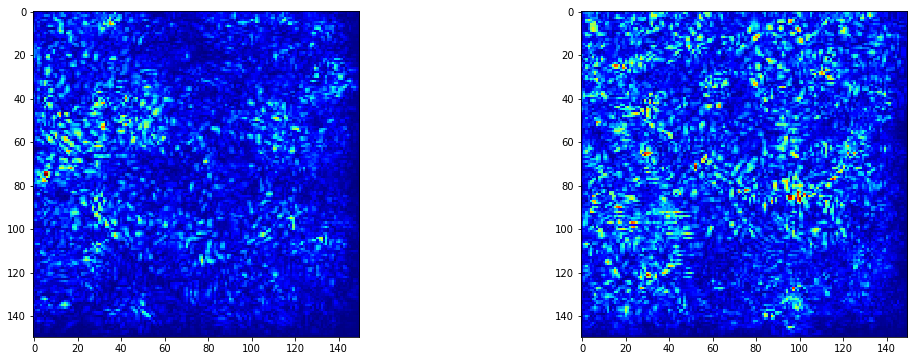

In [5]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set backprop_modifier='guided'. For rectified saliency or deconv saliency, use backprop_modifier='relu'.

<Figure size 1296x432 with 0 Axes>

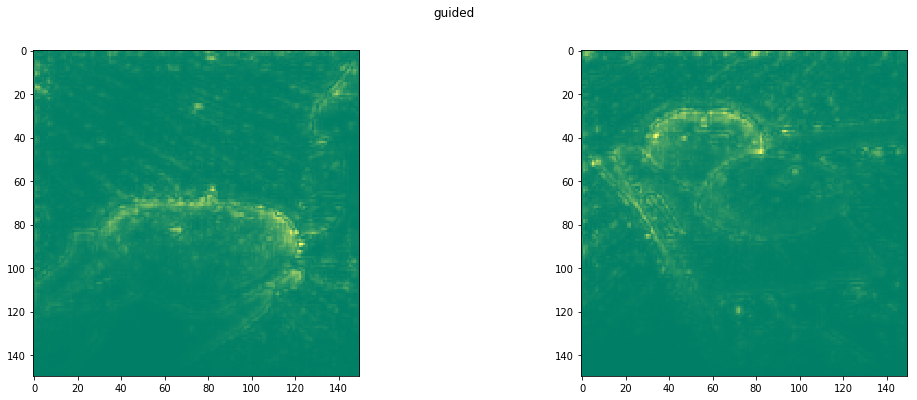

<Figure size 1296x432 with 0 Axes>

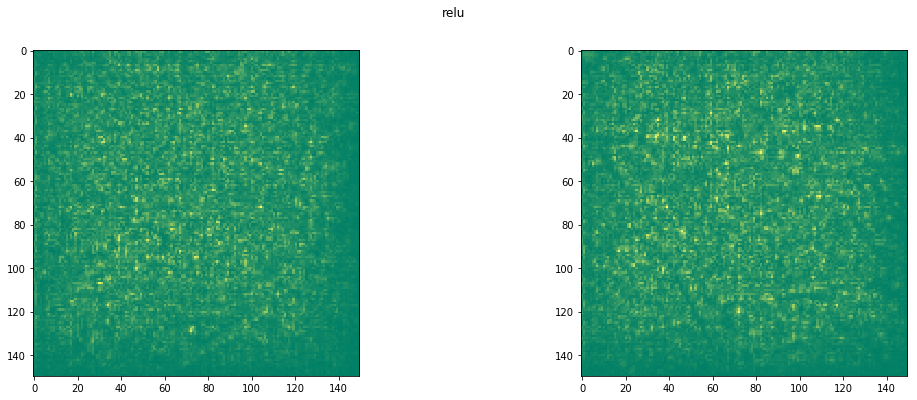

In [26]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_saliency(model, layer_idx, filter_indices=20, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='summer')

guided saliency is definitely better. I am not sure whats going on with rectified saliency.



# grad-CAM - vanilla, guided, rectified
These should contain more detail since they use Conv or Pooling features that contain more spatial detail which is lost in Dense layers. The only additional detail compared to saliency is the penultimate_layer_idx. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if penultimate_layer_idx is not defined, it searches for the nearest pre layer. For our architecture, that would be the block5_pool layer after all the Conv layers. Here is the model summary for reference.



<Figure size 1296x432 with 0 Axes>

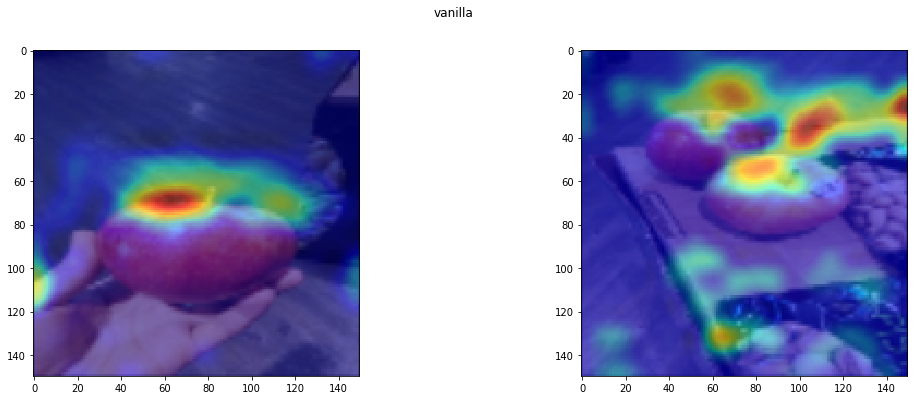

<Figure size 1296x432 with 0 Axes>

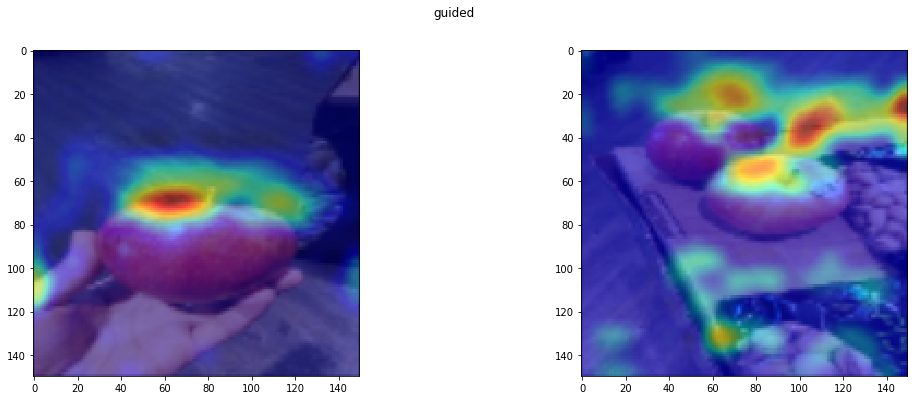

<Figure size 1296x432 with 0 Axes>

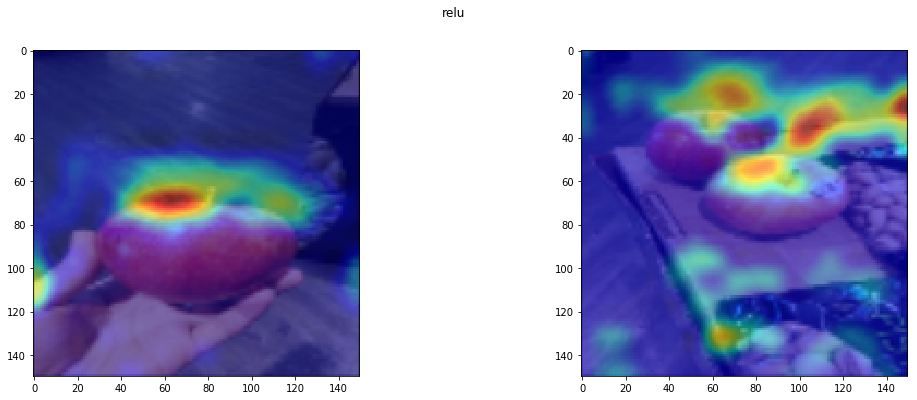

In [7]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(model, layer_idx, filter_indices=20, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

guided grad-CAM wins again. It far less noisy than other options.